## Дипломный проект


# «Модель прогнозирования стоимости жилья для агентства недвижимости»

Задача — разработать модель, которая позволила бы агентству
недвижимости обойти конкурентов по скорости и качеству совершения
сделок.


Необходимо:
1. Провести разведывательный анализ и очистку исходных данных. Во многих
признаках избавится от дублирующиеся категории, ошибки ввода,
жаргонные сокращения и т .д. необходимо отыскать закономерности,
самостоятельно расшифровать все сокращения, найти синонимы в
данных, обработать пропуски и удалить выбросы.
2. Выделить наиболее значимые факторы, влияющие на стоимость
недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.


Описание данных: 

'status' — статус продажи; 

'private pool' и 'PrivatePool' — наличие собственного бассейна;

'propertyType' — тип объекта недвижимости;

'street' — адрес объекта;

'baths' — количество ванных комнат;

'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

'fireplace' — наличие камина;

'city' — город;

'schools' — сведения о школах в районе;

'sqft' — площадь в футах;

'zipcode' — почтовый индекс;

'beds' — количество спален;

'state' — штат;

'stories' — количество этажей;

'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

Для оценки качества модели будут использоваться метрики MAE (Mean Absolute Error) – это среднее арифметическое модуля отклонения предсказанного значения от реального и MAPE (Mean Absolute Percent Error), которая показывает на сколько процентов в среднем предсказание модели отклоняется от реального значения.

In [2]:
import pandas as pd, numpy as np, re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn import metrics
from tqdm import tqdm
from sklearn.base import clone
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold

In [3]:
df = pd.read_csv('data_n.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Исходный датасет состоит из 18 признаков и 377185 объектов. Проведём последовательный анализ каждого признака..

In [5]:
df.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

In [6]:
num_cols = []
cat_cols = []
bin_cols = []

# 6. fireplace
камин; тип данных - object

In [7]:
df.fireplace.nunique()

1652

In [136]:
df.fireplace.isna().sum()

158595

In [137]:
df.fireplace.value_counts()[:50]

fireplace
yes                                      32405
Yes                                      13330
1                                         2332
Not Applicable                            1677
2                                          400
No                                         234
Fireplace YN                               129
0                                          124
Gas/Gas Logs                                82
Living Room                                 67
1 Fireplace                                 55
Wood                                        45
3                                           43
Special Features                            40
Wood Burning                                38
Gas Logs, In Great Room                     29
Fireplace Features                          24
Family Room                                 22
Gas                                         20
Gas Logs, In Living Room                    20
Living Room, Wood Burning                   19
Fam

В столбце содержится 238 уникальных значений и 164011 пропусков. Логично предположить, что здесь пропуск означает отсутствие камина. Поэтому целесообразно заполнить все пропуски значением 'no'.

In [138]:
df.fireplace = df.fireplace.fillna('no')

Некоторые значения имеют различное написание, но одинаковый смысл. Приведём их к единообразию. Для начала приведём всё к нижнему регистру.

In [139]:
df['fireplace'] = df['fireplace'].apply(lambda x: str(x).lower())
df.fireplace.value_counts()[:50]

fireplace
no                                                        158829
yes                                                        45735
1                                                           2332
not applicable                                              1677
2                                                            400
fireplace yn                                                 129
0                                                            124
gas/gas logs                                                  82
living room                                                   67
1 fireplace                                                   55
wood                                                          45
3                                                             43
special features                                              40
wood burning                                                  38
gas logs, in great room                                       29
fireplace featu

In [140]:
#Заменим значение '0' на 'no'.

df['fireplace'] = df['fireplace'].apply(lambda x: 'no' if x=='0' else x)

In [141]:
#Проведем бинарное кодирование столбца: заменим все значения, которые не равны 'no' на 'yes'.

df['fireplace'] = df['fireplace'].apply(lambda x: 'yes' if x!='no' else x)
bin_cols.append('fireplace')

# 7. city
город; тип данных - object

In [142]:
df.city.nunique()

1560

In [143]:
df.city.isna().sum()

10

In [144]:
df.city.value_counts()[:50]

city
Houston             13523
San Antonio          9955
Miami                8072
Jacksonville         6348
Dallas               5153
Las Vegas            4756
Chicago              4370
Orlando              4217
New York             3971
Tampa                3874
Austin               3644
Fort Worth           3546
Philadelphia         3421
Fort Lauderdale      2890
Atlanta              2766
Palm Coast           2520
Detroit              2508
Charlotte            2501
Brooklyn             2239
Cleveland            2167
Saint Petersburg     2030
Lehigh Acres         1992
Indianapolis         1921
Memphis              1911
El Paso              1833
Ocala                1764
Nashville            1763
Kissimmee            1710
Reno                 1450
Portland             1417
Port Charlotte       1292
Denver               1244
Cape Coral           1207
Raleigh              1172
Chattanooga          1081
Fresno               1081
Sacramento           1022
Washington            998
Hialeah

Столбец имеет 1575 уникальных значений и 10 пропусков. Заполним пропуски самым популярным городом - это Houston.

In [145]:
df['city'] = df['city'].fillna('Houston')
df.city.value_counts()[:10]

city
Houston         13533
San Antonio      9955
Miami            8072
Jacksonville     6348
Dallas           5153
Las Vegas        4756
Chicago          4370
Orlando          4217
New York         3971
Tampa            3874
Name: count, dtype: int64

In [146]:
cities_with_freqs = list(df.city.value_counts())
top_cities_count = int(np.percentile(cities_with_freqs, 50))
top_cities_count

8

Выделим 9 самых популярных городов, которые описывают около 50% примеров - это Houston, San Antonio, Miami, Jacksonville, Dallas, Las Vegas, Chicago, Orlando, Tampa, остальные назовём other.

In [147]:
all_cities = set(df.city.value_counts().index)
main_cities = set(df.city.value_counts().index[:9])
cities_to_drop = list(all_cities - main_cities)
df.loc[df['city'].isin(cities_to_drop), 'city'] = 'other'

In [148]:
cat_cols.append('city')

# 8. schools
данные о близлежащих школах; тип данных - object

In [8]:
df.schools.nunique()

297365

In [9]:
df.schools.isna().sum()

0

In [10]:
df.schools.loc[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

В столбце типом данных является строка, в которой закодирован список. В списке в свою очередь заключен словарь. Применим функцию eval для раскодировки списка.

In [11]:
df.schools = df.schools.apply(eval)
df.schools.loc[0]

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

Здесь содержатся данные о школах, расположенных рядом с домом, такие как: rating - рейтинги школ, Distance - расстояния до школ, Grades - возрастной уровень школ и name - названия школ. Из данного столбца можно создать такие признаки как: средний рейтинг школ - 'average_school_rating', количество рядом расположенных школ - 'number_of_schools' и среднее расстояние до школ - 'average_distance_to_school'. Извлечём данные.

Средний рейтинг школ - average_school_rating.
Извлечём показатели рейтингов школ в столбец average_school_rating.

In [153]:
df['average_school_rating'] = df['schools'].apply(lambda x: x[0]['rating'])
df['average_school_rating'].isna().sum()

0

In [154]:
for i in range(5):
    print(df['average_school_rating'].loc[i])

['4/10', 'None/10', '4/10']
['9/10', '9/10', '10/10', '9/10']
['4/10', '5/10', '5/10']
[]
['4', '2', '2']


In [ ]:

#Извлечём числовые показатели и посчитаем средний рейтинг.

pattern = re.compile('\d+')

for i in df.index:
    sum_ratings = 0
    count = 0
    for item in df['average_school_rating'].loc[i]:
        if (len(pattern.findall(item)) != 0) & ('None' not in item):
            sum_ratings += int(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        df['average_school_rating'].loc[i] = 0
    else:
        df['average_school_rating'].loc[i] = round(sum_ratings/count, 1)
     

In [157]:
df['average_school_rating'].value_counts()

average_school_rating
6.0    12581
4.0    11791
5.0    11218
3.0    10710
3.3     9548
       ...  
1.4        7
5.1        5
2.1        4
1.2        3
1.9        2
Name: count, Length: 85, dtype: int64

In [158]:
#Посмотрим сколько в столбце нулевых значений.

len(df[df['average_school_rating'] == 0])

2247

In [159]:

# Отфильтруем нули в столбце и посчитаем среднее
round(df[df['average_school_rating'] != 0]['average_school_rating'].median())

5

In [160]:
# Заменим средним арифметическим нулевые значения
df['average_school_rating'] = df['average_school_rating'].apply(lambda x: 5 if x == 0 else x)

<Axes: >

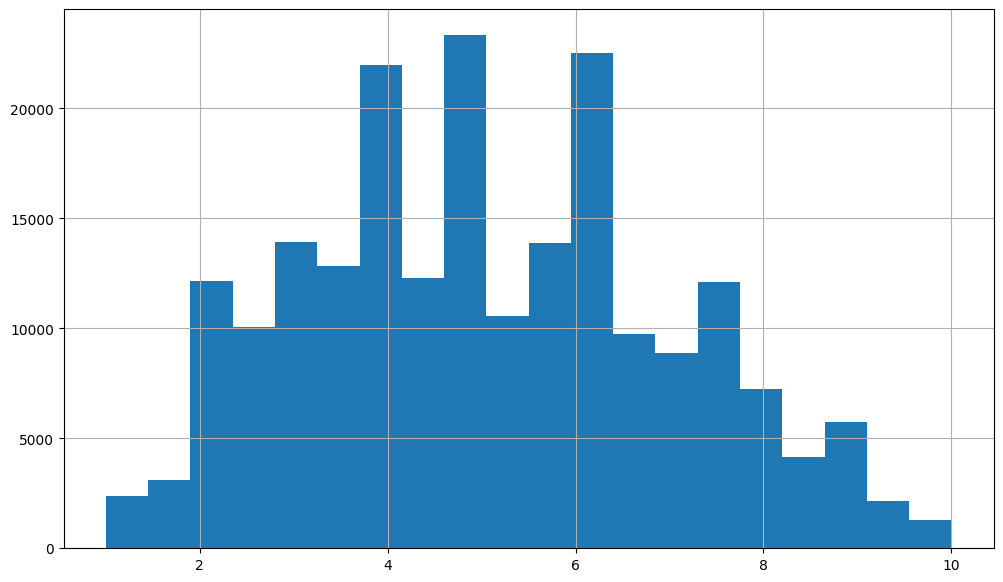

In [161]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df['average_school_rating'].hist(bins=20)

In [162]:
num_cols.append('average_school_rating')

Количество рядом расположенных школ - 'number_of_schools.

In [163]:
df['number_of_schools'] = df['schools'].apply(lambda x: len(x[0]['rating']))
type(df['number_of_schools'][0])

numpy.int64

In [164]:
df['number_of_schools'].value_counts()

number_of_schools
3     129821
2      21355
5      12968
8      12940
4      12443
1       5028
6       4354
7       2091
24      1748
0       1717
22      1368
13       864
12       688
63       532
11       434
15       422
10       377
14       366
65       326
49       152
61       108
9         91
16        20
17        10
26         8
21         4
19         3
Name: count, dtype: int64

Нулевое значение мы принимаем за отсутсвие информации о школе, поэтому заменим эти значения на медианное количество школ. Посчитаем медианное количество школ, расположенных около дома.

In [165]:
round(df['number_of_schools'].median())

3

In [166]:
df['number_of_schools'] = df['number_of_schools'].apply(lambda x: 3 if x == 0 else x)
df['number_of_schools'].value_counts()

number_of_schools
3     131538
2      21355
5      12968
8      12940
4      12443
1       5028
6       4354
7       2091
24      1748
22      1368
13       864
12       688
63       532
11       434
15       422
10       377
14       366
65       326
49       152
61       108
9         91
16        20
17        10
26         8
21         4
19         3
Name: count, dtype: int64

<Axes: >

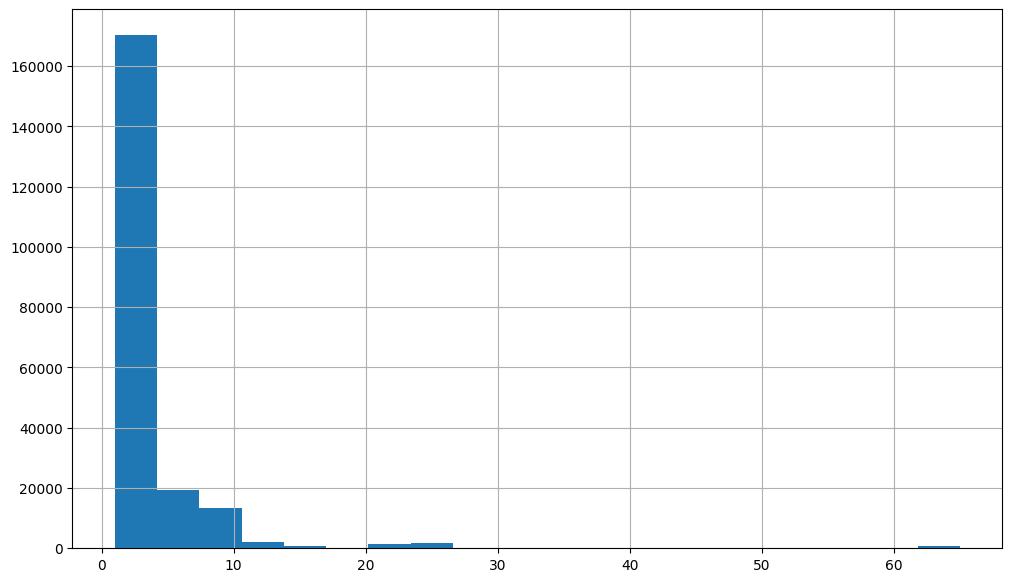

In [167]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df['number_of_schools'].hist(bins = 20)

Визуально заметны выбросы - отфильтруем их, воспользовавшись функцией outliers_z_score.

In [169]:
# Поиск выбросов методом z-score (поиск по отклонению). Возвращает массив индексов значений столбца, определённых как выбросы

def outliers_z_score(ys, threshold=3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores = [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [170]:
df['number_of_schools'].loc[outliers_z_score(df['number_of_schools'], threshold = 2)].sort_values()

118737    15
190790    15
86667     15
144656    15
86606     15
          ..
165229    65
88187     65
87844     65
98058     65
95309     65
Name: number_of_schools, Length: 4701, dtype: int64

In [171]:
#Выявлено 4701 выбросов. Удалим их.

df.drop(outliers_z_score(df['number_of_schools'], threshold = 2), inplace = True)
df.reset_index(inplace = True, drop = True)

<Axes: >

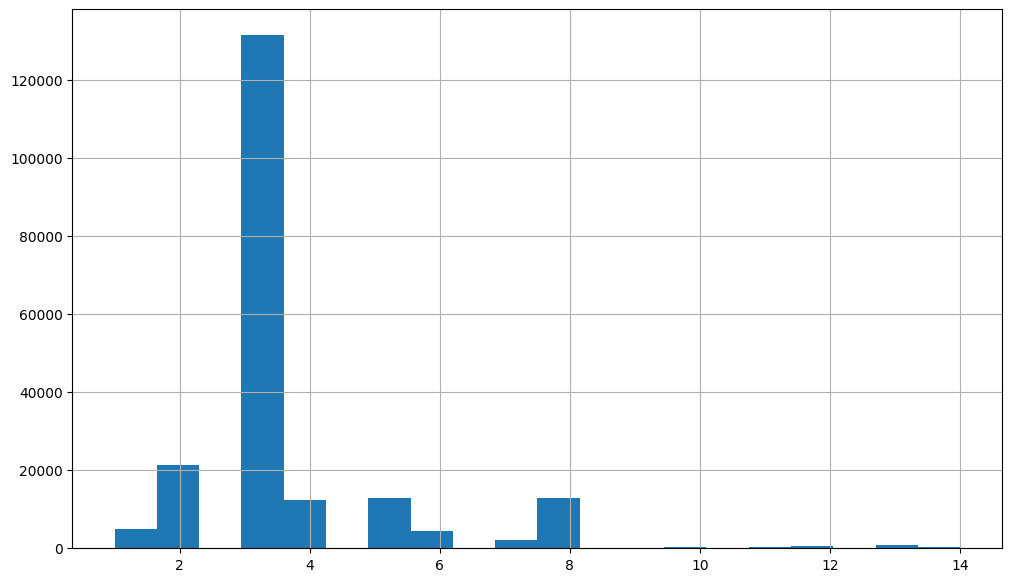

In [172]:
plt.figure(figsize = (12,7))
df['number_of_schools'].hist(bins = 20)

In [173]:
num_cols.append('number_of_schools')

Среднее расстояние до школ в милях - 'average_distance_to_school'.

In [174]:
df['average_distance_to_school'] = df['schools'].apply(lambda x: x[0]['data']['Distance'])
df['average_distance_to_school'].isna().sum()

0

In [175]:
#Пропуски отсутствуют. Посмотрим на структуру данных.

for i in range(5):
    print(df['average_distance_to_school'].loc[i])

['1.65mi', '1.32mi', '1.01mi']
['1.05mi', '0.1mi', '1.05mi', '0.81mi']
['5.96mi', '3.25mi', '3.03mi']
[]
['0.7 mi', '0.4 mi', '2.2 mi']


In [ ]:
#Извлечём числовые показатели и посчитаем среднее расстояние до окружающих школ.

pattern = re.compile('\d+[.]\d+')

for i in df.index:
    sum_distances = 0
    count = 0
    for item in df['average_distance_to_school'].loc[i]:
        if len(pattern.findall(item)) != 0:
            sum_distances += float(pattern.findall(item)[0])
            count += 1
        else:
            continue
    if count == 0:
        df['average_distance_to_school'].loc[i] = 0
    else:
        df['average_distance_to_school'].loc[i] = round(sum_distances/count, 1)

In [178]:
df['average_distance_to_school'].value_counts()

average_distance_to_school
1.1     8879
1.2     8520
0.9     8252
1.0     8147
1.4     7728
        ... 
37.9       1
24.0       1
31.7       1
26.8       1
27.1       1
Name: count, Length: 312, dtype: int64

In [179]:
#Посмотрим сколько в столбце нулевых значений.

len(df[df['average_distance_to_school'] == 0])

1965

Нулевое значение подразумевает отсутствие информации о рейтингах школ. Таких значений 2001. Заменим нули медианным значением, округлённым до целого.

In [180]:
# Отфильтруем нули в столбце и посчитаем среднее
round(df[df['average_distance_to_school'] != 0]['average_distance_to_school'].median())

2

In [181]:
# Заменим средним арифметическим нулевые значения
df['average_distance_to_school'] = df['average_distance_to_school'].apply(lambda x: 2 if x == 0 else x)

In [183]:
#Далее для лучшей интерпретации расстояния целесообразно перевести мили в км.

df['average_distance_to_school'] = df['average_distance_to_school'].apply(lambda x: x*1.6)

<Axes: >

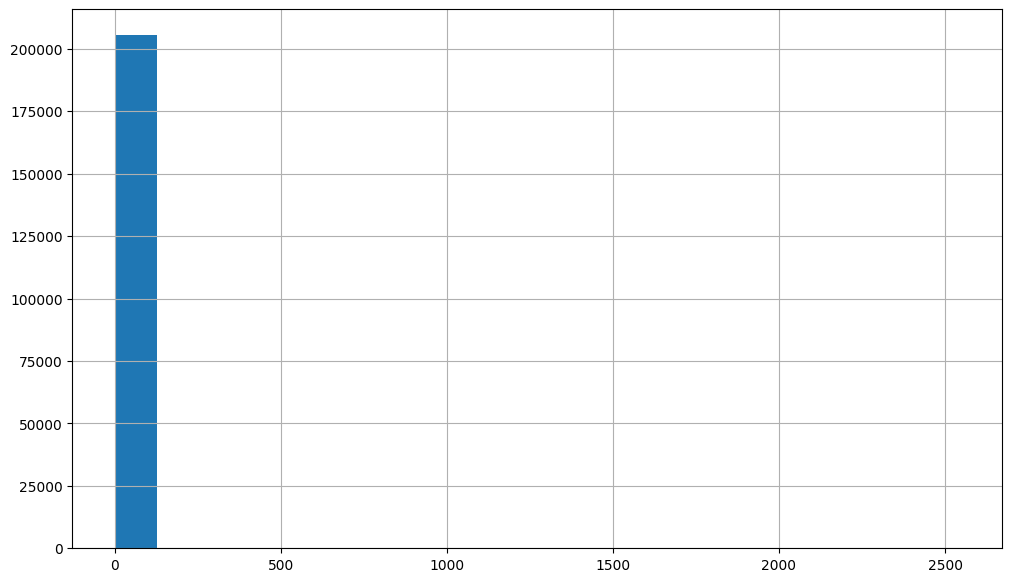

In [184]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df['average_distance_to_school'].hist(bins=20)

In [185]:
#Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

df['average_distance_to_school'].loc[outliers_iqr(df['average_distance_to_school'])].sort_values()

7930         9.92
65087        9.92
119286       9.92
8263         9.92
107178       9.92
           ...   
125934    1160.80
163871    1160.80
202674    1160.80
59801     2545.28
194439    2545.28
Name: average_distance_to_school, Length: 19531, dtype: float64

In [186]:
df = df.drop(outliers_iqr(df['average_distance_to_school']))
df.reset_index(inplace = True, drop = True)

<Axes: >

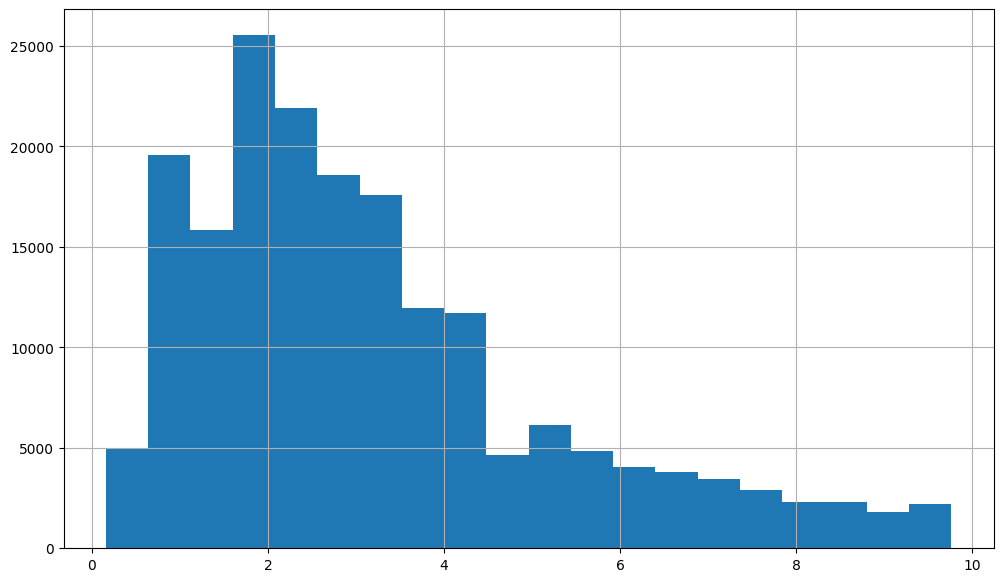

In [187]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df['average_distance_to_school'].hist(bins=20)

In [188]:
num_cols.append('average_distance_to_school')
df.drop('schools', axis = 1, inplace = True)

# 9. sqft
жилая площадь в квадратных футах; тип данных - object

In [189]:
df.sqft.nunique()

17002

In [190]:
df.sqft.isna().sum()

25218

In [191]:
df.sqft.value_counts()[:50]

sqft
0             4529
1,200 sqft     424
1,800 sqft     309
2,000 sqft     295
1,500 sqft     295
1,000 sqft     289
1,400 sqft     284
1,100 sqft     283
1,600 sqft     255
2,400 sqft     222
1,300 sqft     217
2,200 sqft     213
--             206
960 sqft       203
1,440 sqft     203
2,100 sqft     197
3,000 sqft     184
1,120 sqft     176
1,320 sqft     165
2,500 sqft     163
1,900 sqft     162
1,700 sqft     161
1,250 sqft     159
900 sqft       157
1,152 sqft     156
2,300 sqft     150
1,200          149
1,350 sqft     146
800 sqft       146
1,450 sqft     145
1,080 sqft     143
1,056 sqft     143
1,050 sqft     143
1,650 sqft     141
1,260 sqft     141
1,344 sqft     136
-- sqft        133
1,500          128
1,248 sqft     127
1,680 sqft     126
1,008 sqft     125
2,600 sqft     123
1,170 sqft     123
1,296 sqft     120
850 sqft       119
1,560 sqft     119
840 sqft       117
1,100          116
1,750 sqft     115
1,040 sqft     110
Name: count, dtype: int64

В столбце 17002 уникальных значений и 25218 пропуска. Преобразуем столбец в числовой тип данных и заполним пропуски и значения, которые будем считать пропусками, средним арифметическим. Пропусками также будем считать значения '0', '--' и '-- sqft'. Сначала отфильтруем пропуски и все значения, которые считаем пропусками, затем преобразуем столбец в числовой формат, переведём все значения в квадратные метры (m^2) и посчитаем медиану.

In [192]:
pattern = re.compile('\d+[,]?\d+')

# Фильтруем все значения, которые считаем пропусками
sub_df = df[(df.sqft != '0') & (df.sqft != '--') & (df.sqft != '-- sqft') & (pd.isna(df.sqft) != True)]
# Убираем запятые
sub_df['sqft'] = sub_df['sqft'].apply(lambda x: x.replace(',', ''))

C:\Users\yanas\AppData\Local\Temp\ipykernel_93008\2663428157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['sqft'] = sub_df['sqft'].apply(lambda x: x.replace(',', ''))


In [194]:
df['sqft'] = df['sqft'].apply(lambda x: '1847' if (x == '0') | (x == '--') | (x == '-- sqft') | (pd.isna(x) == True) else x)

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат с размерностью m^2.

In [195]:
pattern = re.compile('\d+[,]?\d+')

# Выделяем числовые значения
df['sqft'] = df['sqft'].apply(lambda x: '1847' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['sqft'] = df['sqft'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['sqft'] = df['sqft'].apply(lambda x: int(x))

# Приводим всё к размерности [кв.м.]
df['sqm'] = df['sqft'].apply(lambda x: round(x/10.764))

In [196]:
#Удалим столбец sqft, так как он больше не нужен.

df.drop('sqft', axis = 1, inplace = True)

<Axes: >

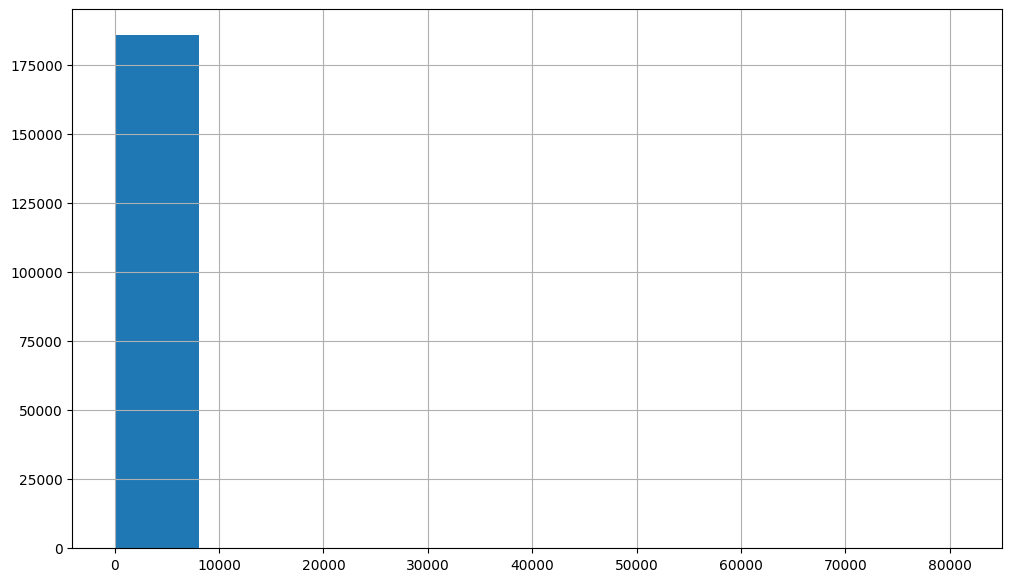

In [197]:
#Посмотрим на гистограмму распределения признака:

plt.figure(figsize = (12,7))
df.sqm.hist()

In [198]:
#Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

df.sqm.loc[outliers_iqr(df.sqm)].sort_values()

131648        5
134617        5
92768       351
153480      351
14464       351
          ...  
12414     54632
152281    62993
22405     72843
60619     73774
99824     80977
Name: sqm, Length: 10284, dtype: int64

In [199]:
#Удалим их.

df.drop(outliers_iqr(df.sqm), inplace = True)
df.reset_index(inplace = True, drop = True)

<Axes: >

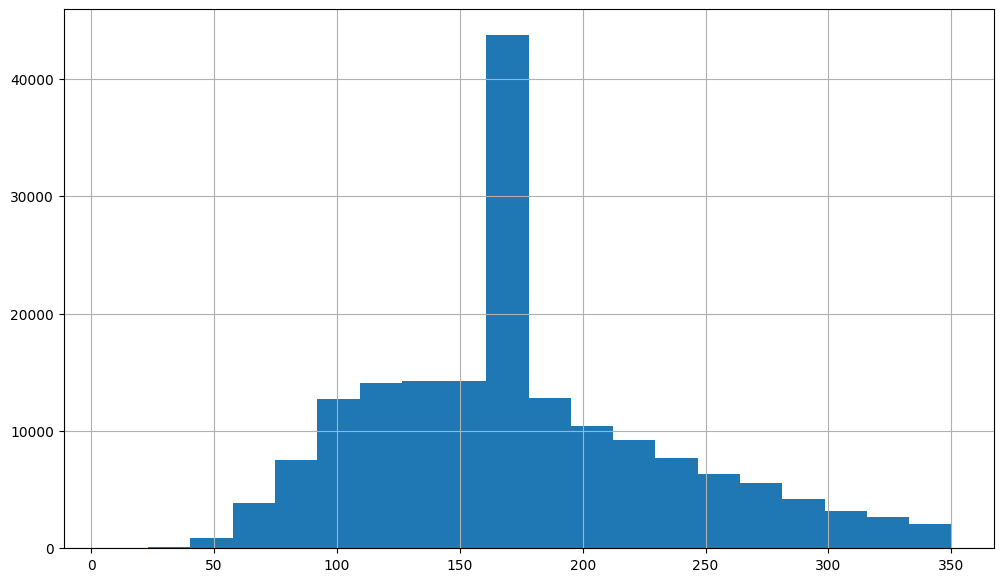

In [200]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df.sqm.hist(bins=20)

In [201]:
num_cols.append('sqm')

# 10. zipcode
почтовый индекс; тип данных - object.

In [202]:
df.zipcode.nunique()

3689

In [203]:
df.zipcode.isna().sum()

0

Данный признак не несёт никакой смысловой нагрузки, поэтому удалим его.

In [204]:
df.drop('zipcode', axis = 1, inplace = True)

# 11. beds
количество спальных комнат; тип данных - object

In [205]:
df.beds.nunique()

85

In [206]:
df.beds.isna().sum()

35238

In [207]:
df.beds.value_counts()[:50]

beds
3 Beds     34438
4 Beds     21390
3          17206
2 Beds     12986
4          10182
3 bd        8538
2           6484
4 bd        5163
5 Beds      4291
2 bd        3120
Baths       3083
3.0         2550
5           1978
4.0         1617
1           1359
5 bd        1078
6 Beds      1014
1 bd         531
-- bd        439
Bath         412
2.0          383
0            364
6            298
             257
7 Beds       244
8 Beds       223
5.0          206
6 bd         159
9 Beds        83
6.0           62
7             49
8             43
10 Beds       32
7 bd          30
64 Beds       24
8 bd          23
0.0           23
12 Beds       17
1.0           15
11 Beds       15
9              7
9 bd           6
8.0            6
7.0            4
12             4
10             3
11             2
18 Beds        2
11 bd          2
16 Beds        2
Name: count, dtype: int64

Данный признак является слишком грязным, к тому же здесь очень много пропусков. Принимаем решение не использовать его и удалить

In [208]:
df.drop('beds', axis = 1, inplace = True)

# 12. state
штат; тип данных - object.

In [209]:
df.state.nunique()

36

In [210]:
df.state.isna().sum()

0

In [211]:
df.state.value_counts()[:10]

state
FL    52158
TX    47340
NC     9536
NY     9243
TN     8472
CA     7728
NV     6181
OH     5156
WA     5050
IL     4818
Name: count, dtype: int64

In [212]:
states_with_freqs = list(df.state.value_counts())
top_states_count = int(np.percentile(states_with_freqs, 85))
top_states_count

7341

In [213]:
#Выделим 6 самых популярных штатов, которые описывают 85% случаев. Остальные штаты представим значением other.

df.state.value_counts().index[:6]

Index(['FL', 'TX', 'NC', 'NY', 'TN', 'CA'], dtype='object', name='state')

In [214]:
all_states = set(df['state'].value_counts().index)
main_states = set(df['state'].value_counts().index[:6])
states_to_drop = list(all_states - main_states)
df.loc[df['state'].isin(states_to_drop), 'state'] = 'other'

In [215]:
cat_cols.append('state')

# 13. stories
количество этажей; тип данных - object.

In [216]:
df.stories.nunique()

141

In [217]:
df.stories.isna().sum()

62000

In [218]:
df.stories.value_counts()[:50]

stories
1.0                      41216
2.0                      34216
1                         9430
2                         6861
3.0                       6455
0.0                       3736
0                         2256
3                         1421
One                       1309
9.0                       1184
4.0                       1145
2.00                       677
Two                        391
1.50                       336
4                          263
9                          244
1.00                       221
5.0                        220
1 Story                    218
One Story                  187
2 Story                    169
8.0                        128
6.0                        123
Ranch/1 Story               96
7.0                         80
1 Level, Site Built         80
Two Story or More           68
6                           57
1 Level                     56
Three Or More               54
Lot                         51
5                           47


In [219]:
# Данный признак является слишком грязным, к тому же здесь очень много пропусков. Принимаем решение не использовать его и удалить.

df.drop('stories', axis = 1, inplace = True)

# 14. mls-id
уникальный идентификатор продажи; тип данных - object.

In [220]:
df['mls-id'].nunique()


15282

In [221]:
df['mls-id'].isna().sum()

160424

In [222]:
#Большинство значений данного столбца пропущены, поэтому удалим его.

df.drop('mls-id', axis = 1, inplace = True)

# 15. PrivatePool
наличие бассейна; тип данных - object.

In [223]:
df.PrivatePool.nunique()

2

In [224]:
df.PrivatePool.isna().sum()

158272

In [225]:
df.PrivatePool.value_counts()

PrivatePool
yes    12673
Yes     4777
Name: count, dtype: int64

In [226]:
#Данный столбец дублирует столбец private pool. Удалим его.

df.drop('PrivatePool', axis = 1, inplace = True)

# 16. MlsId
уникальный идентификатор продажи; тип данных - object.

In [227]:
df.MlsId.nunique()

115668

In [228]:
df.MlsId.isna().sum()

40625

In [229]:
df.MlsId.value_counts()[:50]

MlsId
NO MLS                      19
 A, Houston, TX 77008       13
No MLS #                    12
 B, Houston, TX 77008        9
 B, Houston, TX 77007        8
No                           7
 A, Austin, TX 78721         6
 A, Houston, TX 77018        5
1412350                      5
1520876                      4
 B, Austin, TX 78751         4
U8054073                     4
3555874                      4
 B, Austin, TX 78721         4
DCDC437828                   4
30656755                     4
 A, Austin, TX 78704         4
3565174                      4
3571699                      4
 B, Houston, TX 77054        4
3535121                      4
DCDC435032                   4
 A, Austin, TX 78745         4
 C, Houston, TX 77007        4
DCDC447282                   4
 101, Dallas, TX 75204       4
10061790                     4
1027692                      4
682831                       4
 1, Washington, DC 20010     4
 A, Austin, TX 78723         4
 B, Houston, TX 77057        4
F1

В датасете необходимо удалить дубликаты. Это удобно сделать по столбцу MlsId. В данном столбце 115668 уникальных значений и 40625 пропусков. Отфильтруем их, а потом удалим дубликаты.

In [230]:
df1 = df[df.MlsId.isnull() == False]
df2 = df[df.MlsId.isnull() == True]

In [231]:
df1.drop_duplicates(subset = 'MlsId', inplace = True)

C:\Users\yanas\AppData\Local\Temp\ipykernel_93008\4035173818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop_duplicates(subset = 'MlsId', inplace = True)


In [232]:
df = pd.concat([df1, df2], axis = 0)
df.reset_index(inplace = True, drop = True)

In [233]:
df.shape

(156293, 18)

In [234]:
df.drop('MlsId', axis = 1, inplace = True)


# 17. target

In [235]:
df.target.nunique()

25536

In [236]:
df.target.isna().sum()

1102

In [237]:
df.target.value_counts()[:50]

target
$225,000    752
$275,000    693
$250,000    689
$249,900    665
$299,900    662
$199,900    642
$350,000    613
$325,000    612
$175,000    573
$375,000    544
$235,000    541
$399,000    533
$215,000    528
$299,000    525
$265,000    517
$185,000    512
$239,900    511
$165,000    510
$150,000    504
$425,000    499
$285,000    497
$179,900    487
$450,000    486
$149,900    484
$189,900    484
$399,900    480
$349,900    473
$169,900    463
$269,900    453
$315,000    452
$220,000    444
$159,900    440
$499,000    439
$125,000    437
$295,000    435
$259,900    434
$210,000    428
$245,000    424
$195,000    404
$229,900    404
$300,000    403
$200,000    401
$279,900    401
$289,900    399
$199,000    399
$139,900    398
$219,900    395
$145,000    391
$135,000    377
$230,000    365
Name: count, dtype: int64

Столбец имеет 25536 уникальных значений и 1102 пропусков. Преобразуем столбец в числовой тип данных и заполним пропуски медианой. Сначала отфильтруем пропуски, затем преобразуем столбец в числовой формат и посчитаем среднее арифметическое.

In [238]:
pattern = re.compile('\d+[,]?\d+')

# Фильтруем пропуски
sub_df = df[pd.isna(df.target) != True]

In [240]:
# Убираем запятые
sub_df['target'] = sub_df['target'].apply(lambda x: x.replace(',', ''))


C:\Users\yanas\AppData\Local\Temp\ipykernel_93008\4043068672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['target'] = sub_df['target'].apply(lambda x: x.replace(',', ''))


In [242]:
#Теперь в исходном датафрейме df заполним пропуски значением '255000'.

df['target'] = df['target'].fillna('255000')

Снова проделаем те же операции со столбцом, что и в датафрейме sub_df для того, чтобы получить числовой формат.

In [243]:
pattern = re.compile('\d+[,]?\d+')

# Выделяем цифровые показатели
df['target'] = df['target'].apply(lambda x: '255000' if len(pattern.findall(x)) == 0 else pattern.findall(x)[0])

# Убираем запятые
df['target'] = df['target'].apply(lambda x: x.replace(',', ''))

# Переводим в числовой формат
df['target'] = df['target'].apply(lambda x: int(x))

<Axes: >

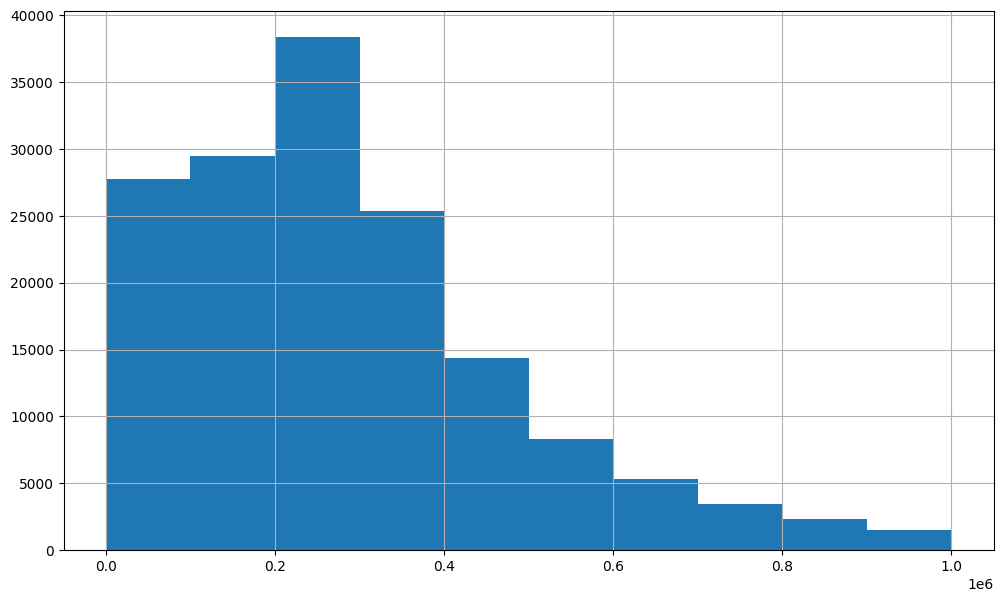

In [244]:
#Посмотрим на гистограмму распределения признака:

plt.figure(figsize = (12,7))
df.target.hist()

In [245]:
#Отфильтруем выбросы. Для этого воспользуемся функцией outliers_iqr.

df.target.loc[outliers_iqr(df.target)].sort_values()

110317    747831
151093    747990
118361    748000
34116     748000
52606     748000
           ...  
81472     999999
75085     999999
13452     999999
52719     999999
53239     999999
Name: target, Length: 6079, dtype: int64

In [246]:
 #Удалим их.

df = df.drop(outliers_iqr(df.target))
df.reset_index(inplace = True, drop = True)

<Axes: >

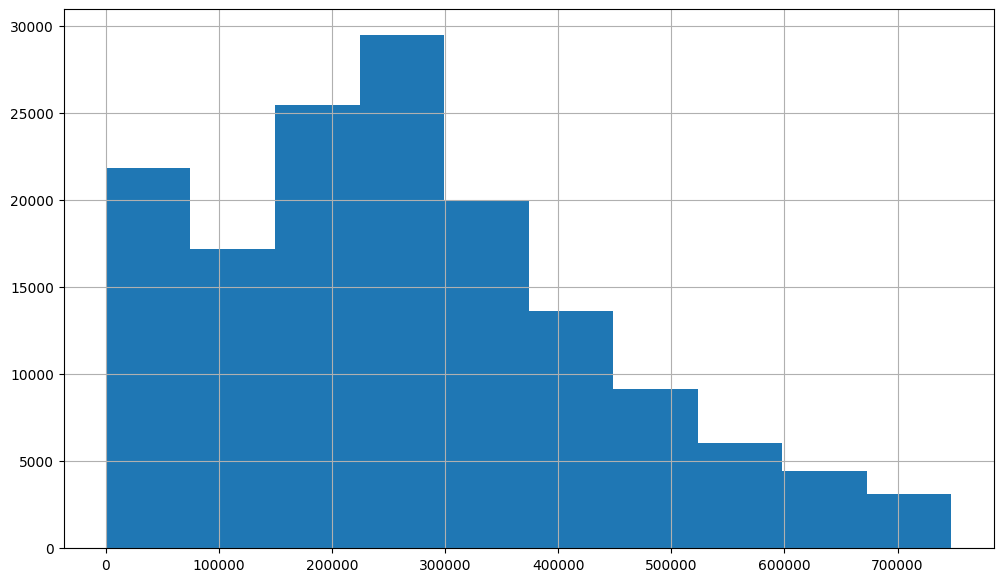

In [247]:
#Посмотрим на гистограмму распределения:

plt.figure(figsize = (12,7))
df.target.hist()


In [248]:
num_cols.append('target')
df.shape

(150214, 17)

# Feature engineering
Создадим полиномиальные признаки на основе столбцов sqm и price/sqm.

In [249]:
pf = PolynomialFeatures(2)

poly_features = pf.fit_transform(df[['sqm', 'price/sqm']])
new_df = pd.DataFrame(poly_features, columns = ['1', 'sqm', 'price/sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2'])
new_df.drop(['1', 'sqm', 'price/sqm'], axis = 1, inplace = True)
df = pd.concat([df, new_df], axis = 1)

In [250]:
#Таким образом мы получили ещё три числовых признака sqm^2, sqm_price/sqm и price/sqm^2.

df.shape

(150214, 20)

In [251]:
#Выгрузим данные в csv для дальнейшего обучения.

df.to_csv('data_preproc.csv', index = False)

В результате EDA получен датасет с размерностью (150214, 20). При этом размерность исходного датасета (377185, 18). Получено 8 числовых признаков (пропуски в них заменены на медиану, выбросы найдены методом IQR и удалены), 7 категориальных признаков (в них сокращено количество уникальных значений) и 2 бинарных признака. В результате feature engineering было получено ещё 3 числовых признака.

# prediction ML

In [ ]:
df = pd.read_csv('data_preproc.csv')
df.head()

Качество обученной модели будем смотреть по двум метрикам: MAE, MAPE.

In [252]:
#Определим функцию для расчета метрики MAPE.

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [253]:
df.columns[:]

Index(['propertyType', 'fireplace', 'city', 'state', 'target', 'sale_status',
       'full_baths', 'year_built', 'remodeling', 'heating', 'parking',
       'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools',
       'average_distance_to_school', 'sqm', 'sqm^2', 'sqm_price/sqm',
       'price/sqm^2'],
      dtype='object')

# Подготовка данных к машинному обучению¶
Обработка числовых переменных

In [254]:
num_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', 
            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']

<Axes: >

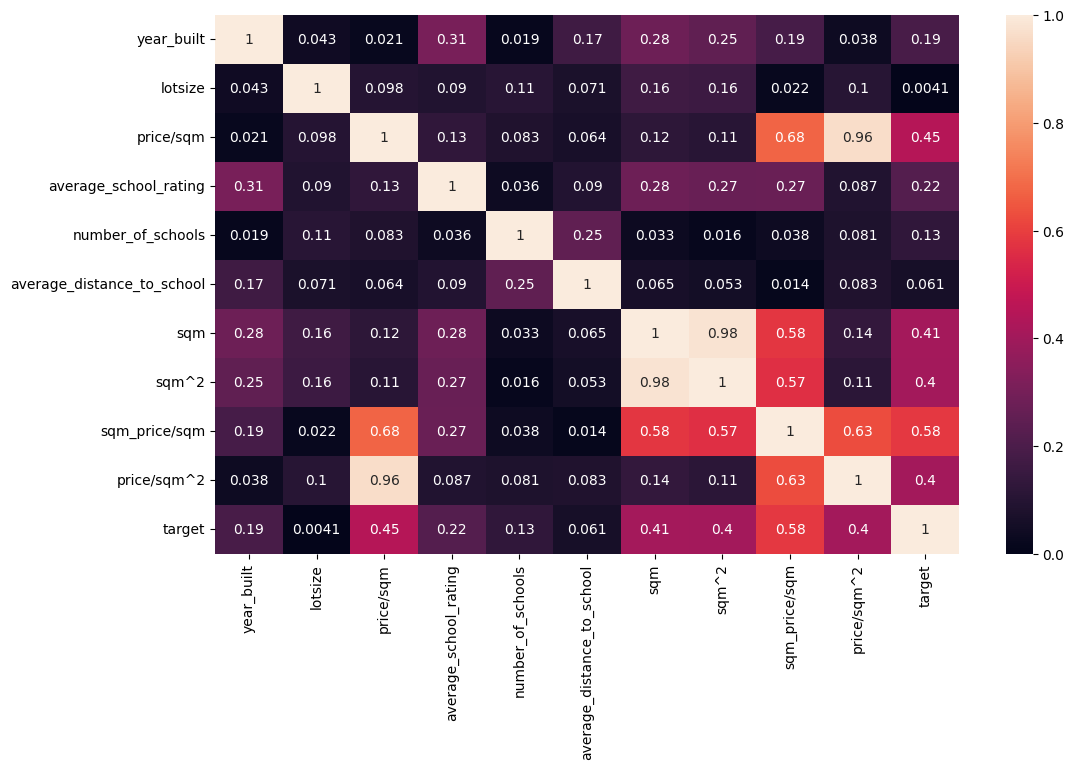

In [255]:
#Оценим корреляцию числовых переменных.

plt.figure(figsize = (12, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Самая высокая корреляция есть у признаков price/sqm и sqm, что логично так как во многом цена дома определяется жилой площадью и ценой за квадратный метр. Прологарифмируем числовые признаки для того, чтобы сгладить распределение.

In [256]:
for col in num_cols:
    df[col] = np.log(df[col] + 1)  

<Axes: >

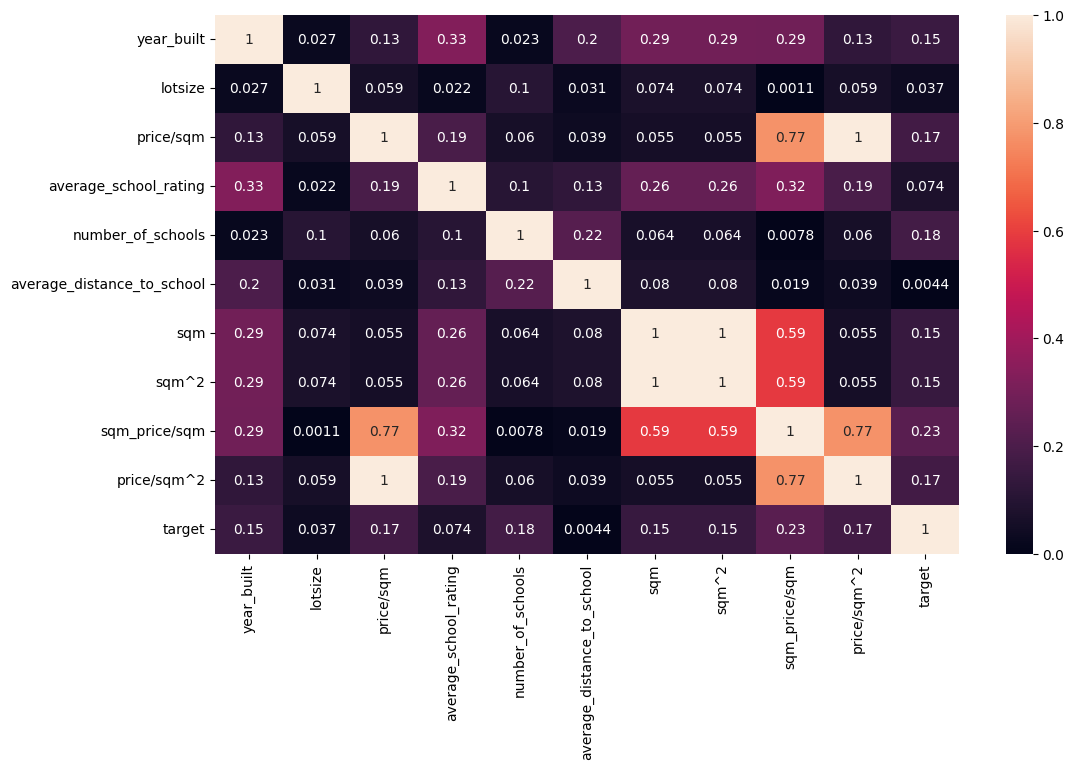

In [257]:
plt.figure(figsize = (12, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

После логарифмирования корреляция признаков уменьшилась.

Обработка бинарных переменных

In [258]:
bin_cols = ['remodeling', 'fireplace']

In [259]:
# Применим LabelEncoder ко всему набору бинарных переменных.

label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [260]:
# Обработка категориальных переменных¶
cat_cols = ['sale_status', 'propertyType', 'full_baths', 'heating', 'parking', 'city', 'state']


In [261]:
# Осуществим dummy-кодирование категориальных переменных.

X_cat = pd.get_dummies(df[cat_cols])

Объединим dummy-переменные с датафреймом df, предварительно удалив из него исходные категориальные признаки.

In [262]:
df = pd.concat([df[num_cols + bin_cols], X_cat], axis = 1)

In [263]:
df.shape

(150214, 61)

In [264]:
df.columns

Index(['year_built', 'lotsize', 'price/sqm', 'average_school_rating',
       'number_of_schools', 'average_distance_to_school', 'sqm', 'sqm^2',
       'sqm_price/sqm', 'price/sqm^2', 'target', 'remodeling', 'fireplace',
       'sale_status_active', 'sale_status_for sale', 'sale_status_foreclosure',
       'sale_status_new construction', 'sale_status_no info',
       'sale_status_pending', 'sale_status_pre-foreclosure',
       'propertyType_condo', 'propertyType_land', 'propertyType_multi-family',
       'propertyType_no info', 'propertyType_single-family',
       'propertyType_townhouse', 'full_baths_1', 'full_baths_2',
       'full_baths_more_than_2', 'full_baths_no', 'full_baths_no_info',
       'heating_electric', 'heating_forced air', 'heating_gas',
       'heating_heat pump', 'heating_no info', 'heating_other',
       'parking_1 space', 'parking_2 spaces', 'parking_attached garage',
       'parking_detached garage', 'parking_more_than_2_spaces',
       'parking_no_info', 'parking_

In [265]:
X = df.drop('target', axis = 1)
y = df['target']

Разделим данные на обучающую, валидационную и тестовую выборки.

In [266]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [267]:
# стандартная нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid_test = scaler.transform(X_valid_test)

In [268]:
y_valid_test = (np.exp(y_valid_test) - 1).values

# Обучение
GradientBoostingRegressor

In [269]:
gb = GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, 
                               max_features = 20, learning_rate = 0.01, random_state=42)
gb.fit(X_train, y_train)
y_pred_gbr = np.exp(gb.predict(X_valid_test)) - 1

In [270]:
MAE = metrics.mean_absolute_error(y_valid_test, y_pred_gbr)
MAPE = mape(y_valid_test, y_pred_gbr)

In [271]:
print('MAE = {}'.format(round(MAE)))
print('MAPE = {}'.format(round(MAPE)))

MAE = 20046
MAPE = 94


# XGBoost

In [272]:
xb = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, 
                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)
xb.fit(X_train, y_train)
y_pred_xgb = np.exp(xb.predict(X_valid_test)) - 1

In [273]:
MAE = metrics.mean_absolute_error(y_valid_test, y_pred_xgb)
MAPE = mape(y_valid_test, y_pred_xgb)

In [274]:
print('MAE = {}'.format(round(MAE)))
print('MAPE = {}'.format(round(MAPE)))

MAE = 25353
MAPE = 82


# Catboost

In [283]:
'''
# Подготовка данных для алгоритма Catboost

df = pd.read_csv('../input/house-price-prediction-eda/data_preproc.csv')

num_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', 
            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']

# Список числовых переменных для датасета data_preproc_6
#num_cols = ['average_school_rating', 'average_distance_to_school', 'sqm', 'target']

for col in num_cols:
    df[col] = np.log(df[col] + 1)
    
X = df.drop('target', axis = 1)
y = df['target']

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state = 42)

# стандартная нормализация
scaler = StandardScaler()
X_train[list(set(num_cols) - set(['target']))] = scaler.fit_transform(X_train[list(set(num_cols) - set(['target']))])
X_valid_test[list(set(num_cols) - set(['target']))] = scaler.transform(X_valid_test[list(set(num_cols) - set(['target']))])

y_valid_test = (np.exp(y_valid_test) - 1).values
'''

"\n# Подготовка данных для алгоритма Catboost\n\ndf = pd.read_csv('../input/house-price-prediction-eda/data_preproc.csv')\n\nnum_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', \n            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']\n\n# Список числовых переменных для датасета data_preproc_6\n#num_cols = ['average_school_rating', 'average_distance_to_school', 'sqm', 'target']\n\nfor col in num_cols:\n    df[col] = np.log(df[col] + 1)\n    \nX = df.drop('target', axis = 1)\ny = df['target']\n\nX_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)\n#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state = 42)\n\n# стандартная нормализация\nscaler = StandardScaler()\nX_train[list(set(num_cols) - set(['target']))] = scaler.fit_transform(X_train[list(set(num_cols) - set(['target'])

In [284]:
'''
cb = CatBoostRegressor(iterations = 5000,
                       one_hot_max_size = 2,
                       random_seed = 42)
cb.fit(X_train, y_train, 
       cat_features = cat_cols + bin_cols,
       eval_set = (X_valid_test, y_valid_test), 
       logging_level = 'Silent',
       plot = False)
y_pred_cb = np.exp(cb.predict(X_valid_test)) - 1
'''

"\ncb = CatBoostRegressor(iterations = 5000,\n                       one_hot_max_size = 2,\n                       random_seed = 42)\ncb.fit(X_train, y_train, \n       cat_features = cat_cols + bin_cols,\n       eval_set = (X_valid_test, y_valid_test), \n       logging_level = 'Silent',\n       plot = False)\ny_pred_cb = np.exp(cb.predict(X_valid_test)) - 1\n"

In [281]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_cb)
#MAPE = mape(y_valid_test, y_pred_cb)

In [285]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

# Stacking

In [286]:
'''
def compute_meta_feature(reg, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg reg: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_reg = clone(reg)
        folded_reg.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_reg.predict(X_fold_predict)
    
    meta_reg = clone(reg)
    meta_reg.fit(X_train, y_train)
    
    X_meta_test = meta_reg.predict(X_test)
    
    return X_meta_train, X_meta_test
'''

'\ndef compute_meta_feature(reg, X_train, X_test, y_train, cv):\n    """\n    Computes meta-features using the regressor.\n    \n    :arg reg: scikit-learn regressor\n    :args X_train, y_train: training set\n    :arg X_test: testing set\n    :arg cv: cross-validation folding\n    """\n    X_meta_train = np.zeros_like(y_train, dtype=np.float32)\n    for train_fold_index, predict_fold_index in cv.split(X_train):\n        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]\n        y_fold_train = y_train[train_fold_index]\n        \n        folded_reg = clone(reg)\n        folded_reg.fit(X_fold_train, y_fold_train)\n        X_meta_train[predict_fold_index] = folded_reg.predict(X_fold_predict)\n    \n    meta_reg = clone(reg)\n    meta_reg.fit(X_train, y_train)\n    \n    X_meta_test = meta_reg.predict(X_test)\n    \n    return X_meta_train, X_meta_test\n'

In [287]:
'''
def generate_meta_features(regressors, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg regressors: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(reg, X_train, X_test, y_train, cv)
        for reg in tqdm(regressors)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test
'''

'\ndef generate_meta_features(regressors, X_train, X_test, y_train, cv):\n    """\n    Generates metafeatures using a list of classifiers.\n    \n    :arg regressors: list of scikit-learn regressors\n    :args X_train, y_train: training set\n    :arg X_test: testing set\n    :arg cv: cross-validation folding\n    """\n    features = [\n        compute_meta_feature(reg, X_train, X_test, y_train, cv)\n        for reg in tqdm(regressors)\n    ]\n    \n    stacked_features_train = np.vstack([\n        features_train for features_train, features_test in features\n    ]).T\n\n    stacked_features_test = np.vstack([\n        features_test for features_train, features_test in features\n    ]).T\n    \n    return stacked_features_train, stacked_features_test\n'

In [288]:
'''
cv = KFold(n_splits = 5, shuffle = True)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators = 1500, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, bootstrap = True, 
                          max_features = 20, n_jobs = -1, random_state = 42),
    GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, 
                              max_features = 20, learning_rate = 0.01, random_state = 42),
    xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, 
                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)
], X_train, X_valid_test, y_train.values, cv)
'''

"\ncv = KFold(n_splits = 5, shuffle = True)\n\nstacked_features_train, stacked_features_test = generate_meta_features([\n    RandomForestRegressor(n_estimators = 1500, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, bootstrap = True, \n                          max_features = 20, n_jobs = -1, random_state = 42),\n    GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, \n                              max_features = 20, learning_rate = 0.01, random_state = 42),\n    xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, \n                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)\n], X_train, X_valid_test, y_train.values, cv)\n"

In [289]:
#st = LinearRegression()
#st.fit(stacked_features_train, y_train)
#y_pred_st = np.exp(st.predict(stacked_features_test)) - 1

In [290]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_st)
#MAPE = mape(y_valid_test, y_pred_st)

In [291]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

# Выводы:
Было обучено 3 бустинговых модели сделан стекинг. Все алгоритмы показали неудовлетворительное качество. Далее приводятся оценки качества на обученных моделях.

GradientBoostingRegressor

GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, max_features = 20, learning_rate = 0.01, random_state=42)

MAE = 20046 $, MAPE = 94 %

CatBoostRegressor

CatBoostRegressor(iterations = 5000, one_hot_max_size = 2, random_seed = 42)

MAE = 30085 $, MAPE = 88 %

XGBRegressor

XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)

MAE = 25353 $, MAPE = 82 %

Stacking

Stacking (RandomForestRegressor, GradientBoostingRegressor, XGBRegressor)

MAE = 26963 $, MAPE = 99 %

Таким образом лучшее качество показал алгоритм GradientBoostingRegressor MAE = 20046 $ и MAPE = 94 %.